# Making sense of the news using Machine Learning

There are times when people need to make sense of a large set of text. These could be conversations on social media or online forums, information repositories or knowledge bases, news articles, customer reviews on e-commerce websites, e-mails from customers to get support, ... etc. For example businesses, researchers, medical professionals, employers, lawyers, political campaigns all find it valuable to understand what people are talking about or writing about. But with the vast amounts of content being produced today, it is hard for this to be done through manual effort alone. Fortunately breakthroughs in computer scienece mean that computers can be trained to do the job quite efficiently using Machine Learning. 

This paper describes a way to use Machine Learning techniques to analyze a large collection of news articles, and discover the set of common “topics” in them. The dataset used for project has over one million news headlines that were published over a span of 15 years by the Australian Broadcasting Corporation. 

The specific Machine Learning technique used in this paper is called "Topic modeling". This is a way to look through a large collection of documents and discover the set of common “topics” in there. The challenge is how to extract high quality topics that are meaningful to a human, while being separate and distinct from each other. 

The typical approach that a data scientest follows to solve this challenge is a two step process. First convert the text into a set of numeric information that a computer can work with. This is called pre-processing, and the result is a transformation from a large amount of text into a large matrix of numbers that captures the most relevant information from that text. Then the second step is to train a machine learning model that can identify the set of distinct patterns represented within those numbers. These patterns represent clusters of information - the set of different topics contained within the documents. 

This paper describes a detailed way to do this, and is structured along these lines:
1. A description of how to collect and pre-process the text from the dataset of news headlines - so that it is transformed into a multi-dimensional vector space of numbers.
2. A description of how to train a machine learning model on that vector space, using a common algorithm for topic modeling called Latent Dirichlet Allocation (LDA). 
3. A description of a metric called the "Coherence Score" - which measures the effectiveness of the machine learning, based on how distinct the topics are and how likley they will be meaningful to a human.
4. Using that metric to improve the machine learned model by estimating the number of different topics that might be represented in the dataset of news headlines (since that isn't known at the beginning), and also by trying two different software implementations of the LDA algorithm.
4. Finally a way to use that machine learned model to predict what topic a new document would belong to, that is not part of the set of news headlines that were used to train the machine learning model.

## Get the dataset of news headlines

The dataset is a list of over one million news headlines that were published over a span of 15 years. It has been downloaded as a CSV file from Kaggle (https://www.kaggle.com/therohk/million-headlines). The headlines were sourced from the Australian Broadcasting Corporation (http://www.abc.net.au/) from Feb 19 2003, to Dec 31 2017. 

This dataset is also described as a corpus, or a collection of documents, and we need a way to manipulate this corpus using Python, so that we can build a statistical model of the topics contained within this corpus. So We use the Python Data Analysis Library (pandas). This is a Python package that lets us build a dataframe from the CSV file downloaded from Kaggle with the data. A dataframe is a flexible, expressive data structure that makes it easy to manipulate "relational" or "labeled" data.

In [1]:
import pandas as pd

data = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False);
data_text = data[['headline_text']]
data_text['index'] = data_text.index
documents = data_text

The Kaggle dataset home page claims that there are over one million news headlines. Lets check that claim by looking at the number of documents in the dataframe that we created using pandas. Looking at the length we can see that there are just over 1.1 million news headlines in this dataset.

In [2]:
len(documents)

1103665

Now lets take a quick look at the data to visually inspect it. This is always a good idea before analyzing the data and building a machine learning model. If the data is not clean then none of our results will be accurate. This would be a case of GIGO - or Garbage In / Garbage Out. However looking at a few headlines it appears that the dataset is clean.

In [3]:
documents[:5]

,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


## Preprocessing the text before the Topic Model can be trained

The headline data needs to be pre-processed before we can build a Machine Learning model. This is what we need to do to the data:
1. First we take each headline, and run sentence detection on it to split the text into sentences, and then we split the sentences into words. This is called tokenization - which is the process of breaking content into small, usable chunks of text. The most common approach to tokenization of English is to split strings based on the occurrence of whitespace such as spaces and line breaks. Puntuation is also removed, and all the words are transformed into lower case alphabets for consistency. 
2. We will remove words with fewer than 3 characters.
3. We will filter out stopwords, which are commonly occuring words like 'the', 'and', and 'a'. These words add little value when performing topic modeling, as the algorithms don’t rely on sentence structure. 
4. We will perform lemmatization on the words. This means that words in third person are changed to first person, and verbs in past / future tenses are changed into present tense.
5. We will perform stemming - which reduces words to their root, or simpler, form e.g. 'dogs' to 'dog', or from 'running' to 'run'.
For more details on stemming and lemmatization, see here: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In this project we will use the following Python libraries. 

1) gensim

gensim is a Python library for topic modeling - and the name comes from "generate similar". It is designed to find a short list of the most similar documents to a given document. It uses "Latent Semantic Methods" to perform unsupervised semantic modelling from plain text. The design decisions are described in this academic paper from 2010: https://radimrehurek.com/gensim/lrec2010_final.pdf 

According to the website the author has tried hard to make this library "robust, efficient and hassle free" - and the library has been used in over a thousand research papers and student theses.

2) NLTK or "Natural Language Toolkit" 

NLTK is a library used to build Python programs that can work with natural language datasets. It has built-in support for over 50 different tools for Natural Language Processing including pre-trained Machine Learning models, and a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.

3) NumPy 

NumPy is a Python library that adds data structures to handle large, multi-dimensional arrays and matrices. It also provides a set of mathematical functions that can operate on those data structures.

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)

C:\Users\atanu\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Next we will use the Natural Language Toolkit (NLTK) to download WordNet, which is described on Wikipedia as a "lexical database for the English language" - or as a combination of a dictionary and a thesaurus for English.

In [5]:
import nltk
nltk.download('wordnet')

[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

### Using Stemming to reduce words to their root forms

In order to build up a topic model from our corpus, we need to make sure that the algorithms can treat all variations of the same word similarly. For example articles containing the words 'bank', 'banks', 'banking', 'banker', 'banked', ... are all likely about the same topic of banking. So the statistical model needs to be told that all variations of the same word are essentially the same. Stemming is the process of reducing a word to a root, or simpler form, which isn’t necessarily a word on its own. The goal is to improve the performance of NLP algorithms by organizing under a single heading all the different variant forms of a word which all share a common meaning. 

There are many different algorithms for stemming, each with their own design goals. Some are aggressive, reducing words to the smallest root possible, whereas others are lighter, preferring to do basic things like removing s or ing from words. A common stemming algorithm is called the Porter stemmer, named after Martin Porter who developed it, but most people now use an improved version of this called the Porter2 stemmer. The Natural Language Toolkit (NTLK) includes the Porter2 stemmer, but confusingly calls it the Snowball stemmer - alhough Snowball is really a framework developed by Martin Porter to describe stemming algorithms for a variety of languages in addition to English. The most aggressive stemming algorithm is called the Lancaster stemmer - which reduces words to stems which are so short that they can barely be readable by a human. A Lancaster stemmer is useful when working with very large text datasets, as it reduces the computer hardware footprint required for stemming. 

In this project we'll just use the SnowballStemer algortithm included in the Natural Language Toolkit (NTLK) - which is documented here: http://snowballstem.org. The following example shows how the stemmer can reduce a few sample words down to their stemmed form, using one of the unit tests that ships in the NTLK.

In [6]:
stemmer = SnowballStemmer('english')
original_words = ['caresses', 'flies', 'dies', 'mules', 'denied','died', 'agreed', 'owned', 
           'humbled', 'sized','meeting', 'stating', 'siezing', 'itemization','sensational', 
           'traditional', 'reference', 'colonizer','plotted']
singles = [stemmer.stem(plural) for plural in original_words]
pd.DataFrame(data = {'original word': original_words, 'stemmed': singles})

,original word,stemmed
0,caresses,caress
1,flies,fli
2,dies,die
3,mules,mule
4,denied,deni
5,died,die
6,agreed,agre
7,owned,own
8,humbled,humbl
9,sized,size


### Lemmatization leverages vocabulary to make better sense of the words

Lemmatization has the same goal as stemming above - it is a way to reduce words to their base (or root) form - but the approach is different. Stemmers follow an algorithmic approach to removing prefixes and suffixes of words, and the result may or may not be a real word that you would find in a dictionary. However a Lemmatizer uses a dictionary as a reference, and so Lemmatization converts the words of a sentence to their dictionary form or 'lemma'. For example, a Lemmatizer when run on the words amusement, amusing, and amused, would result in a lemma for each of these that is 'amuse'. So the result is always a dictionary word. Similary the lemma of the word ‘computers’ is ‘computer’, the lemma for ‘running’ is ‘run’, and the lemma for ‘mice’ is ‘mouse’. 

When should you use stemming vs lemmatization? If it is important that the result of reduction be a dictionary word, then use lemmatization. Stemming is essentially a crude heuristic process that trims the ends off words with the hope of being correct most of the time. Lemmatization is a way to do things properly with the use of a known vocabulary (i.e. a dictionary lookup). and an analysis of how words are being used in the text. If a lemmatizer is run on the word 'saw', it would attempt to return either 'see' or 'saw' depending on whether the word was being used as a verb or a noun. But a stemmer might only return 's'. However if speed is more important than accuracy, then use a stemmer - as a lemmatizer has to search through a dictionary while stemmers perform simple string operations.

For more technical details on the differences between lemmatization and stemming see here: https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html 

Just as we did above with the SnowballStemer, we will show how the WordNetLemmatizer algortithm included in the Natural Language Toolkit (NTLK) can reduce a few sample words down to their reduced form. The NLTK Lemmatization method is based on WordNet’s built-in morphy function. 

In [7]:
print(WordNetLemmatizer().lemmatize('go', pos='v'))
print(WordNetLemmatizer().lemmatize('going', pos='v'))
print(WordNetLemmatizer().lemmatize('gone', pos='v'))
print(WordNetLemmatizer().lemmatize('went', pos='v'))

go
go
go
go


### Combining dictionary lemmatization with stemmer

For this study we will use a two step approach to pre-process the news headlines. First we will use wordnet lemmatization i.e. use a dictionary lookup to find the lemmas, and then after that we will additionally apply a Porter2 stemmer to the word vector. It can be expected that the first step itself will result in most lemmas, and the use of a stemmer after that will catch any missing words. To do this we will create a helper function to pre-process the headlines that combines lemmatization and stemming.

We will also tell our helper function to ignore stop-words. These are words that do not contain important significance, and can usually be safely filtered out to avoid unnecessary information. For example common English stop words are 'as', 'the', 'be', 'are' ... etc.

In [9]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

We will select a random headline to use as an example through this project. This is the 3000th headline from the dataset. The original headline is "Briton makes second big rowing attempt". The pre-processed version of this headline is 'briton', 'make', 'second', 'row', 'attempt'.

In [10]:
doc_sample = documents[documents['index'] == 3000].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized, lemmatized, and stemmed document: ')
print(preprocess(doc_sample))

original document: 
['briton', 'makes', 'second', 'big', 'rowing', 'attempt']


 tokenized, lemmatized, and stemmed document: 
['briton', 'make', 'second', 'row', 'attempt']


Now we pre-process the headlines, and save the results after tokenization, stemming and lemmatiztion into the variable 'processed_docs'.

And as above we will do a quick sanity check by visually inspecting the processed headlines. This is another example of how we are protecting against GIGO - or Garbage In / Garbage Out.

The processed headlines will be the training set that we use for our Machine Learning models in this project.

In [11]:
processed_docs = documents['headline_text'].map(preprocess)

In [12]:
processed_docs[:10]

0            [decid, communiti, broadcast, licenc]
1                               [wit, awar, defam]
2           [call, infrastructur, protect, summit]
3                      [staff, aust, strike, rise]
4             [strike, affect, australian, travel]
5               [ambiti, olsson, win, tripl, jump]
6           [antic, delight, record, break, barca]
7    [aussi, qualifi, stosur, wast, memphi, match]
8            [aust, address, secur, council, iraq]
9                         [australia, lock, timet]
Name: headline_text, dtype: object

## Getting ready to train the Topic Modeling algorithm

We will use Machine Learning in order to perform topic modeling on our corpus of news headlines. However Machine Learning algorithms cannot work with text directly - they operate on numbers. So we need a way to convert our corpus of headlines into a numeric format that the algorithms can understand. One way to do this is to use a Bag of Words model that is extracted from the corpus. This converts each headline (or row in the the corpus) into a vector of numbers - the vocabulawhich describe the occurence of words within the headline.  

This method of constructing a bag-of-words model from the text (or BoW for short) is also known as feature extraction, or feature encoding. Conceptually this is a two step process:
1) First construct the vocabulary of all (or most) words that occur within the corpus
2) Next map each document within the corpus (or headline in this case) into a vector that measures whether each of the known words is present within the document or not.

This approach to convert text into numeric data is very simple and flexible. It is called a “bag” of words, because the model ignores any information about the order or structure of words in the document. Rather the model only keeps track of whether known words occur in each document, and not where they occur within the document. The reasoning behind this is that similar documents have similar content, and that we just need the words in the document (ignoring ordering) in order to learn about the meaning of the document.

So as described here we will first create a dictionary of the 'known words' that occur within the training set.

In [13]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [14]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 broadcast
1 communiti
2 decid
3 licenc
4 awar
5 defam
6 wit
7 call
8 infrastructur
9 protect
10 summit


This project is using unsupervised machine learning - because the news headlines are not labeled data. However even though unsupervised techniques are being used, we can apply some human judgement to the learning process. We will filter out tokens which are not representive of the topics in this dataset - either because they appear too infrequently, or appear too often. And then we will keep only the most frequent tokens so that we are not dealing with a long tail of topics that users might not care about.

To do this we will filter out tokens that appear in less than 15 headlines, or that are in more than 50% of the headlines (e.g. common words like 'the', 'and', ...). And after filtering out these tokens, we will keep only the 100,000 most frequent remaining tokens.

In [15]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

Now we use gensim bag of words - to create a dictionary that has the frequency of how often each token appears in the dataset. This is saved in the variable 'bow_corpus'.

After that we check the tokens in our sample document selected earlier. We can see that tokens 316 ('attempt'), 443 ('second'), 709 ('make'), 1171 ('briton') and 3364 ('row') each appear exactly once in the sample document - which is what we expect.

In [16]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[3000]

[(316, 1), (443, 1), (709, 1), (1171, 1), (3364, 1)]

In [17]:
bow_doc_3000 = bow_corpus[3000]

for i in range(len(bow_doc_3000)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_3000[i][0], 
                                                     dictionary[bow_doc_3000[i][0]], 
                                                     bow_doc_3000[i][1]))

Word 316 ("attempt") appears 1 time.
Word 443 ("second") appears 1 time.
Word 709 ("make") appears 1 time.
Word 1171 ("briton") appears 1 time.
Word 3364 ("row") appears 1 time.


## Building the Topic Model using the LDA algorithm

There are several topic modeling algorithms available, for example latent semantic analysis (LSA), hierarchical Dirichlet process (HDP), and latent Dirichlet allocation (LDA). The LDA algorithm is quite popular, as it has shown good results in practice and so has been widely adopted. The LDA algorithm is the one that we will use here.

We have everything required to train the LDA model, but we also need to provide some parameters for the model training. This is a summary of everything that is needed to train the model:

1. The corpus of news headlines
2. The dictionary of commonly used words within the corpus
3. The number of topics
4. Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics. According to the Gensim docs, both defaults to 1.0/num_topics prior.
5. chunksize is the number of documents to be used in each training chunk. 
6. update_every determines how often the model parameters should be updated
7. passes is the total number of training passes

There is an easy to use implementation of the LDA algorithm in Python’s Gensim package. And so we will start with this implementation of the algorithm, by loading the python libraries from gensim, and then applying them to the dataset of news headlines. 

In [18]:
from gensim import corpora, models

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)

In [19]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.029*"elect" + 0.019*"death" + 0.018*"say" + 0.017*"hospit" + 0.016*"tasmanian" + 0.015*"labor" + 0.013*"deal" + 0.013*"china" + 0.011*"polit" + 0.011*"talk"
Topic: 1 
Words: 0.019*"nation" + 0.018*"coast" + 0.016*"help" + 0.016*"countri" + 0.015*"state" + 0.015*"chang" + 0.014*"health" + 0.013*"tasmania" + 0.013*"hour" + 0.013*"indigen"
Topic: 2 
Words: 0.019*"canberra" + 0.018*"market" + 0.014*"rise" + 0.014*"west" + 0.014*"australian" + 0.013*"turnbul" + 0.013*"price" + 0.013*"share" + 0.011*"victoria" + 0.010*"bank"
Topic: 3 
Words: 0.063*"polic" + 0.024*"crash" + 0.019*"interview" + 0.019*"miss" + 0.018*"shoot" + 0.016*"arrest" + 0.015*"investig" + 0.013*"driver" + 0.012*"search" + 0.011*"offic"
Topic: 4 
Words: 0.029*"charg" + 0.027*"court" + 0.021*"murder" + 0.018*"woman" + 0.018*"face" + 0.016*"die" + 0.016*"alleg" + 0.015*"brisban" + 0.015*"live" + 0.015*"jail"
Topic: 5 
Words: 0.035*"australia" + 0.022*"melbourn" + 0.021*"world" + 0.017*"open" + 0.014*"final

## Visualizing the results of the topic model

Above we printed out the keywords in each topic. But visualization of the topic model is important in order to test our original goal - that the topics are meaningful to a human, while at the same time being separate and distinct from each other. There are different ways to visualize the topic model, by distinguishing between the different topics using the keywords in each topic and their corresponding weights.
The first visualization we will try is a word cloud - with the size of the keywords proportional to the corresponding weight. 

In [20]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 10 Axes>

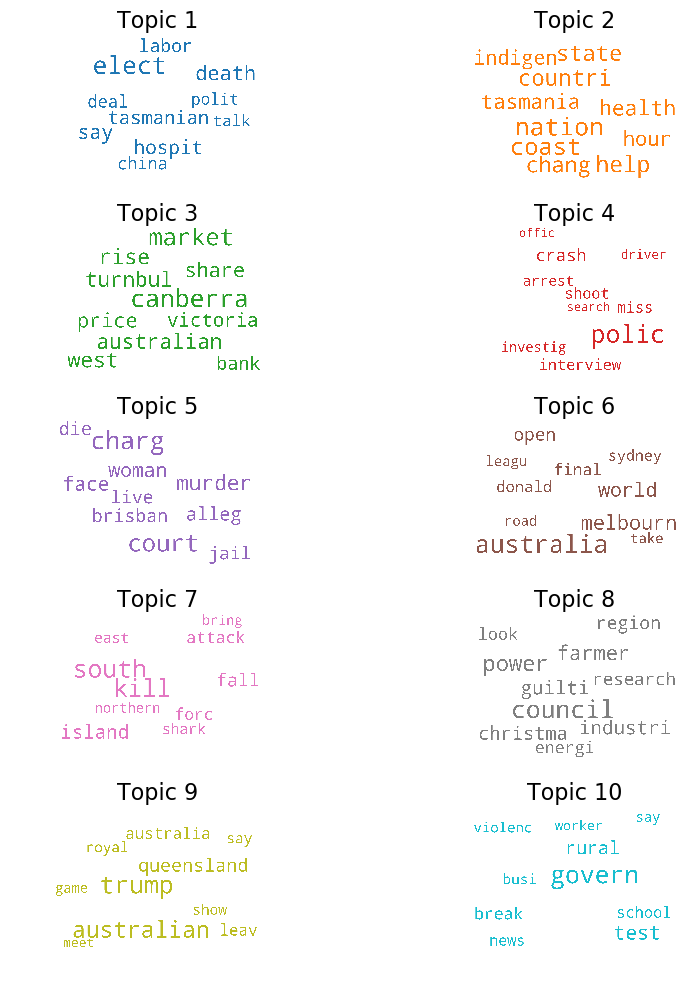

In [21]:
fig

## Evaluate how well the topic model can be interpreted by a human

We need a way to measure how good the topic model is. One metric for this is called topic coherence, and it measures how well the model can be interpreted by a human. Therefore the coherence score probides a way to compare different topic models. And fortunately gensim provides a convenient way to calculate this score. You can see below that the coherence score for our topic model is 0.22.

After calculating this, we will evaluate ways to improve the topic model further.

In [22]:
from gensim.models.coherencemodel import CoherenceModel

# Compute Perplexity
# print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.23043337647143503


## Improving the Topic Model by reducing the impact of non representative words

The technique used above with "bag of words" is based on analyzing the frequency at which words appear in documents. So the principle used is that a document can be represented by the words that appear most frequently in it. These are words with high "term frequency" or tf - and mathematically this can be expressed as:

TF(t,doc) = (Number of times the term 't' appears in the document 'doc') / (Total number of terms in the document 'doc').

You can see that the normalized Term Frequency (TF) is the number of times a word appears in a document, divided by the total number of words in that document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is divided by the document length (i.e. the total number of terms in the document) for normalization. 

However while this principle seems reasonable, it doesn't work very well in practice, as some words like 'this', 'a', 'and', ...  occur very frequently across all documents - but aren't representative of the content in the documents. So term frequency is not a very useful metric by itself, in order to summarize a document or a paragraph using just a few keywords. 

The way to fix this, is to also include a measure of how unique a word is i.e. how infrequently the word occurs across all documents in the corpus. This metric is called the "inverse document frequency" or idf - and mathematically this can be expressed as:

IDF(t) = log_e(Total number of documents / Number of documents with term t in it). 

So the Inverse Document Frequency (IDF) is calculated as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears. It is a measure of how important a term is. 

While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones. So a commonly used metric is the product of tf x idf for each word in the vocabulary that we constructed from the corpus of documents. This is known as the "tf-idf" weight (i.e. the "term frequency-inverse document frequency" weight). This metric can be calculated for each word appearing in a document, from the product of how frequent this word is in that document multiplied by how unique the word is across the entire corpus of documents. 

Words with a high tf-idf score in a document both occur frequently in the document, and also provide the most information about that specific document. And that is why the tf-idf weight is a weight that is often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. 

EXAMPLE:
1. Consider a document containing 100 words wherein the word 'dog' appears 7 times. 
2. The term frequency (i.e., tf) for 'dog' is then (7 / 100) = 0.07. 
3. Now, assume we have a million documents and the word 'dog' appears in one thousand of these. 
4. Then, the inverse document frequency (i.e., idf) is calculated as log(1,000,000 / 1,000) = 3. 
5. Thus, the Tf-idf weight is the product of these quantities: 0.07 * 3 = 0.21.


In [23]:
from gensim import corpora, models

tfidf = models.TfidfModel(bow_corpus)

In [24]:
corpus_tfidf = tfidf[bow_corpus]

In [25]:
from pprint import pprint

for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.5892908644709983),
 (1, 0.38929657403503015),
 (2, 0.4964985198530063),
 (3, 0.5046520328695662)]


## Re-building the topic model using TF-IDF weights

Now we'll generate another LDA model using the TF-IDF weights.

In [26]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)

In [27]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.020*"polic" + 0.019*"charg" + 0.016*"murder" + 0.013*"court" + 0.012*"alleg" + 0.011*"death" + 0.011*"jail" + 0.011*"woman" + 0.010*"arrest" + 0.009*"assault"
Topic: 1 Word: 0.014*"news" + 0.014*"crash" + 0.012*"rural" + 0.010*"north" + 0.008*"south" + 0.007*"korea" + 0.007*"ash" + 0.006*"west" + 0.006*"octob" + 0.006*"die"
Topic: 2 Word: 0.008*"grandstand" + 0.008*"marriag" + 0.007*"septemb" + 0.007*"novemb" + 0.007*"violenc" + 0.006*"malcolm" + 0.006*"domest" + 0.006*"andrew" + 0.005*"quiz" + 0.005*"say"
Topic: 3 Word: 0.009*"christma" + 0.006*"health" + 0.006*"elect" + 0.006*"rugbi" + 0.006*"farm" + 0.005*"stori" + 0.005*"mental" + 0.005*"august" + 0.005*"tasmanian" + 0.005*"indigen"
Topic: 4 Word: 0.018*"countri" + 0.017*"hour" + 0.010*"interview" + 0.009*"govern" + 0.006*"abbott" + 0.005*"wall" + 0.005*"cut" + 0.005*"asylum" + 0.005*"say" + 0.004*"union"
Topic: 5 Word: 0.022*"trump" + 0.007*"michael" + 0.007*"friday" + 0.007*"juli" + 0.006*"video" + 0.005*"anim" +

In [28]:
lda_model_tfidf.save('./saved-state/lda_model_tfidf')

gensim.corpora.MmCorpus.serialize('./saved-state/corpus_tfidf.mm', corpus_tfidf)

## Visualizing the results of the improved topic model

Add the second section on data visualization here - for the improved topic model. This should show how to distinguish different topics using the words in each topic and their corresponding weights.

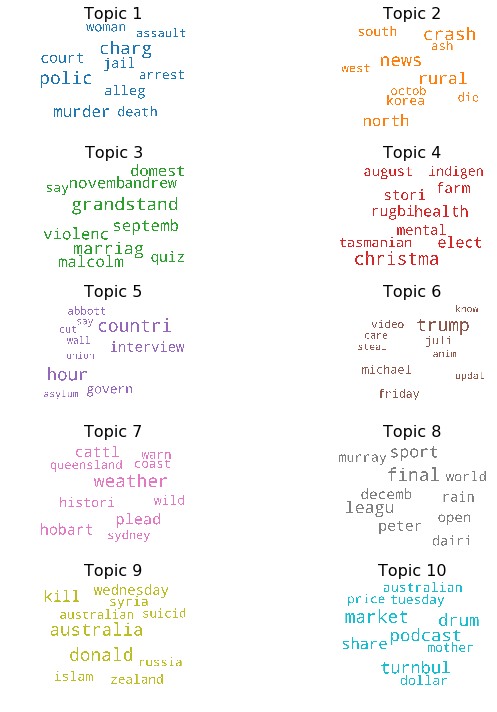

In [29]:
# 1. Wordcloud of Top N words in each topic
cols2 = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud2 = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols2[i],
                  prefer_horizontal=1.0)

topics2 = lda_model_tfidf.show_topics(formatted=False)

fig2, axes2 = plt.subplots(5, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes2.flatten()):
    fig2.add_subplot(ax)
    topic_words = dict(topics2[i][1])
    cloud2.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud2)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## How good is this improved Topic Model?

### Evaluate how well the topic model can be interpreted by a human

We can now re-calulate the topic coherence score. You can see below that using the TF-IDF weights to reduce the impact of non representative words has increased the coherence score for our topic model from 0.22 to 0.37.

In [30]:
%env PYTHONWARNINGS=ignore::DeprecationWarning

from gensim.models.coherencemodel import CoherenceModel

# Compute Perplexity
# print('\nPerplexity: ', lda_model_tfidf.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda_tfidf = CoherenceModel(model=lda_model_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda_tfidf = coherence_model_lda_tfidf.get_coherence()
print('\nCoherence Score: ', coherence_lda_tfidf)

env: PYTHONWARNINGS=ignore::DeprecationWarning

Coherence Score:  0.35672040693123513


In [31]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'})
# os.environ.update({'PATH':r'C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Users\atanu\AppData\Local\Microsoft\WindowsApps;;C:\Program Files\Microsoft VS Code\bin'})

mallet_path = 'C:/mallet-2.0.8/bin/mallet'
lda_model_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=bow_corpus, num_topics=10, id2word=dictionary)

In [32]:
# Show Topics
pprint(lda_model_mallet.show_topics(formatted=False))

[(0,
  [('open', 0.02165142660143809),
   ('world', 0.01864308697507962),
   ('test', 0.017015792757001675),
   ('win', 0.016710033818169878),
   ('final', 0.015936402140722988),
   ('lead', 0.015010917030567686),
   ('australia', 0.013147634369767213),
   ('aussi', 0.011087352661128804),
   ('play', 0.009150195357389106),
   ('live', 0.00903527924615031)]),
 (1,
  [('plan', 0.0466766554293087),
   ('council', 0.03882715278644858),
   ('water', 0.025979106838140427),
   ('rise', 0.019120156490614725),
   ('coast', 0.01775710658842136),
   ('fear', 0.017201481666458567),
   ('concern', 0.01568027635576643),
   ('price', 0.015592874682648687),
   ('industri', 0.014375494235651558),
   ('green', 0.013106088983227203)]),
 (2,
  [('sydney', 0.023464554015781805),
   ('hous', 0.021793019925947885),
   ('home', 0.019995332319900087),
   ('power', 0.015914266070381048),
   ('work', 0.01573975370628518),
   ('melbourn', 0.014280578035411292),
   ('forc', 0.012871863771022958),
   ('worker', 0.0

In [33]:
# Compute Coherence Score

coherence_model_lda_mallet = CoherenceModel(model=lda_model_mallet, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda_mallet = coherence_model_lda_mallet.get_coherence()

print('\nCoherence Score: ', coherence_lda_mallet)


Coherence Score:  0.26195693528592806


In [34]:
# Train model with both Mallet and TF-IDF

lda_model_mallet_tfidf = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=10, id2word=dictionary)

# Compute Coherence Score for model trained using both Mallet and TF-IDF

coherence_model_lda_mallet_tfidf = CoherenceModel(model=lda_model_mallet_tfidf, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda_mallet_tfidf = coherence_model_lda_mallet_tfidf.get_coherence()
print('\nCoherence Score: ', coherence_lda_mallet_tfidf)


Coherence Score:  0.4492683941571956


### Visualizing the overlap across models

An interactive tool to examine the produced topics and the associated keywords is the pyLDAvis package - which comes with an interactive chart. 

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic - because the area of each circle represents the importance of that topic over the entire corpus of documents which were used to train the model.  

The distance between the center of the circles represents the similarity between topics. So two circles that are close by, represnt topics that are similar. 

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

For each topic, the histogram on the right side listed the top 30 most relevant terms. So if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the representative keywords that form the selected topic.

In [35]:
# Visualize the topics
import pyLDAvis
import pyLDAvis.gensim
import gensim

# lda_model_tfidf = gensim.models.LdaMulticore.load('lda_model_tfidf')

pyLDAvis.enable_notebook()
vis_tfidf = pyLDAvis.gensim.prepare(lda_model_tfidf, corpus_tfidf, dictionary)
vis_tfidf

C:\Users\atanu\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.068441  0.116708       1        1  11.489985
0     -0.348744  0.088437       2        1  11.169258
7      0.124686 -0.115200       3        1  10.387480
3      0.103616  0.073808       4        1  10.294313
8     -0.042616 -0.052024       5        1  10.056682
1     -0.105614 -0.211355       6        1   9.837558
6      0.034668 -0.145477       7        1   9.718119
9      0.091390  0.054707       8        1   9.283718
2      0.056601  0.044313       9        1   9.054268
5      0.017572  0.146084      10        1   8.708613, topic_info=      Category         Freq         Term        Total  loglift  logprob
term                                                                   
6594   Default  4369.000000        trump  4369.000000  30.0000  30.0000
417    Default  4782.000000      countri  4782.000000  29.0000  29.0000
1405   Default  4326.000000         hour  4326.000000  28.0000  28.0000
319    Default  5355.000000        charg  5355.000000  27.0000  27.0000
300    Default  3915.000000       murder  3915.000000  26.0000  26.0000
1250   Default  3054.000000         news  3054.000000  25.0000  25.0000
192    Default  3781.000000        crash  3781.000000  24.0000  24.0000
235    Default  7449.000000        polic  7449.000000  23.0000  23.0000
305    Default  2938.000000        alleg  2938.000000  22.0000  22.0000
327    Default  2989.000000         jail  2989.000000  21.0000  21.0000
11891  Default  2287.000000      podcast  2287.000000  20.0000  20.0000
2832   Default  2265.000000         drum  2265.000000  19.0000  19.0000
5656   Default  2185.000000      turnbul  2185.000000  18.0000  18.0000
1530   Default  2215.000000       donald  2215.000000  17.0000  17.0000
284    Default  2725.000000       arrest  2725.000000  16.0000  16.0000
1077   Default  3541.000000        woman  3541.000000  15.0000  15.0000
649    Default  2153.000000      weather  2153.000000  14.0000  14.0000
211    Default  4610.000000        court  4610.000000  13.0000  13.0000
1524   Default  2230.000000      assault  2230.000000  12.0000  12.0000
693    Default  2049.000000     christma  2049.000000  11.0000  11.0000
900    Default  2068.000000      sentenc  2068.000000  10.0000  10.0000
1298   Default  4856.000000    interview  4856.000000   9.0000   9.0000
1097   Default  3808.000000       market  3808.000000   8.0000   8.0000
5337   Default  1726.000000   grandstand  1726.000000   7.0000   7.0000
241    Default  3491.000000        north  3491.000000   6.0000   6.0000
1675   Default  2825.000000        shoot  2825.000000   5.0000   5.0000
141    Default  4096.000000        death  4096.000000   4.0000   4.0000
1246   Default  4846.000000        rural  4846.000000   3.0000   3.0000
1227   Default  1540.000000      marriag  1540.000000   2.0000   2.0000
1221   Default  1583.000000        korea  1583.000000   1.0000   1.0000
...        ...          ...          ...          ...      ...      ...
13185  Topic10   577.202393      myanmar   578.078125   2.4393  -5.8255
712    Topic10   613.656616      general   614.598694   2.4393  -5.7643
12074  Topic10   554.841064       episod   555.700989   2.4393  -5.8650
6532   Topic10   553.578796      richard   554.438721   2.4393  -5.8673
4757   Topic10   540.888000      matthew   541.748169   2.4393  -5.8905
575    Topic10   534.875854  anniversari   535.735962   2.4393  -5.9017
1855   Topic10   564.799927    technolog   565.712341   2.4392  -5.8473
2875   Topic10   529.392700  controversi   530.267029   2.4392  -5.9120
5917   Topic10   470.466431         appl   471.326416   2.4390  -6.0300
1731   Topic10   459.132141      special   459.993683   2.4390  -6.0544
4739   Topic10   448.581268   republican   449.441223   2.4389  -6.0776
2423   Topic10   956.513794         anim   958.351807   2.4389  -5.3204
8709   Topic10   446.913879         mike   447.773804   2.4389  -6.08

In [36]:
# import importlib
# importlib.reload(gensim.models.wrappers)
# from gensim.models.wrappers import LdaMallet

lda_mallet2gensim = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model_mallet_tfidf, iterations=1000)
vis_mallet_tfidf = pyLDAvis.gensim.prepare(lda_mallet2gensim, corpus_tfidf, dictionary)
vis_mallet_tfidf

C:\Users\atanu\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\atanu\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\atanu\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\atanu\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.228358 -0.132144       1        1  10.046715
1      0.033553  0.089641       2        1  10.044132
4     -0.105515 -0.114008       3        1  10.019445
8     -0.020778  0.301059       4        1  10.001205
6      0.078885  0.108141       5        1  10.000315
5     -0.009762  0.329718       6        1   9.997517
9     -0.317461 -0.118304       7        1   9.987092
2      0.216033 -0.142093       8        1   9.985004
0      0.211714 -0.175075       9        1   9.968107
7     -0.315026 -0.146935      10        1   9.950467, topic_info=      Category           Freq        Term          Total  loglift  logprob
term                                                                      
2084   Default  149794.000000      closer  149794.000000  30.0000  30.0000
1048   Default  105126.000000       sport  105126.000000  29.0000  29.0000
649    Default  108840.000000     weather  108840.000000  28.0000  28.0000
1298   Default   54878.000000   interview   54878.000000  27.0000  27.0000
4037   Default   43570.000000   entertain   43570.000000  26.0000  26.0000
1246   Default   34996.000000       rural   34996.000000  25.0000  25.0000
81     Default   23918.000000        busi   23918.000000  24.0000  24.0000
11460  Default   16868.000000  countrywid   16868.000000  23.0000  23.0000
5337   Default    9436.000000  grandstand    9436.000000  22.0000  22.0000
1250   Default   12226.000000        news   12226.000000  21.0000  21.0000
268    Default    8010.000000        open    8010.000000  20.0000  20.0000
98     Default    6776.000000        miss    6776.000000  19.0000  19.0000
549    Default    6522.000000        sale    6522.000000  18.0000  18.0000
6242   Default    6022.000000      corner    6022.000000  17.0000  17.0000
55     Default    5761.000000       water    5761.000000  16.0000  16.0000
319    Default    5316.000000       charg    5316.000000  15.0000  15.0000
64     Default    5065.000000      report    5065.000000  14.0000  14.0000
37     Default    4927.000000   australia    4927.000000  13.0000  13.0000
1839   Default    6695.000000      budget    6695.000000  12.0000  12.0000
171    Default    6971.000000         die    6971.000000  11.0000  11.0000
240    Default    5970.000000        meet    5970.000000  10.0000  10.0000
1194   Default    4517.000000       china    4517.000000   9.0000   9.0000
1265   Default    4502.000000        bell    4502.000000   8.0000   8.0000
511    Default    4440.000000      review    4440.000000   7.0000   7.0000
174    Default    4238.000000       chang    4238.000000   6.0000   6.0000
483    Default    5922.000000        rain    5922.000000   5.0000   5.0000
343    Default    4166.000000        warn    4166.000000   4.0000   4.0000
470    Default    5607.000000         job    5607.000000   3.0000   3.0000
192    Default    4080.000000       crash    4080.000000   2.0000   2.0000
364    Default    4219.000000      hospit    4219.000000   1.0000   1.0000
...        ...            ...         ...            ...      ...      ...
4502   Topic10    1589.453792       syria    1589.453792   2.3076  -4.9470
1107   Topic10    1456.999309       track    1456.999309   2.3076  -5.0340
1300   Topic10    1456.999309       drown    1456.999309   2.3076  -5.0340
4453   Topic10    1192.090344       peter    1192.090344   2.3076  -5.2347
3984   Topic10    1192.090344       drone    1192.090344   2.3076  -5.2347
781    Topic10    1192.090344      worker    1192.090344   2.3076  -5.2347
291    Topic10    1192.090344        vote    1192.090344   2.3076  -5.2347
534    Topic10    1059.635861         ban    1059.635861   2.3076  -5.3525
2027   Topic10    1059.635861     submiss    1059.635861   2.3076  -5.3525
5044   Topic10    1059.635861        juli    1059.635861   2.3076  -5.3525
408    Topic10    1059.635861        stay    1059.635861   2.3076  -5.3525
1870   To

In [37]:
# TEST ! TEST !

print("Mallet Model topics")
for topic in lda_model_mallet_tfidf.show_topics(num_topics=5, num_words=10):
    print(topic)
    
print("Mallet Model converted to gensim topics")
for topic in lda_mallet2gensim.show_topics(num_topics=5, num_words=10):
    print(topic)

Mallet Model topics
(7, '0.348*"closer" + 0.019*"chang" + 0.017*"futur" + 0.017*"shoot" + 0.013*"test" + 0.010*"mine" + 0.010*"green" + 0.009*"stab" + 0.008*"expand" + 0.008*"aussi"')
(5, '0.302*"sport" + 0.015*"year" + 0.013*"attack" + 0.013*"drum" + 0.012*"council" + 0.011*"control" + 0.010*"appeal" + 0.010*"sell" + 0.010*"interview" + 0.008*"reform"')
(6, '0.197*"interview" + 0.047*"countrywid" + 0.030*"miss" + 0.017*"hous" + 0.015*"power" + 0.014*"rise" + 0.014*"entertain" + 0.014*"court" + 0.014*"harvest" + 0.011*"investig"')
(3, '0.185*"weather" + 0.028*"countrywid" + 0.015*"station" + 0.015*"plan" + 0.013*"road" + 0.013*"world" + 0.011*"dead" + 0.010*"return" + 0.010*"approv" + 0.009*"clubhous"')
(0, '0.172*"weather" + 0.042*"grandstand" + 0.029*"sale" + 0.020*"review" + 0.017*"drought" + 0.017*"job" + 0.014*"speak" + 0.014*"elect" + 0.011*"win" + 0.010*"mayor"')
Mallet Model converted to gensim topics
(1, '0.106*"busi" + 0.037*"interview" + 0.022*"report" + 0.020*"bell" + 0.018

In [38]:
lda_model_mallet_4topics = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_tfidf, num_topics=4, id2word=dictionary)

# Compute Coherence Score for model trained using both Mallet and TF-IDF

coherence_model_lda_mallet_tfidf_4topics = CoherenceModel(model=lda_model_mallet_4topics, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda_mallet_tfidf_4topics = coherence_model_lda_mallet_tfidf_4topics.get_coherence()
print('\nCoherence Score: ', coherence_lda_mallet_tfidf_4topics)


Coherence Score:  0.4473196035866921


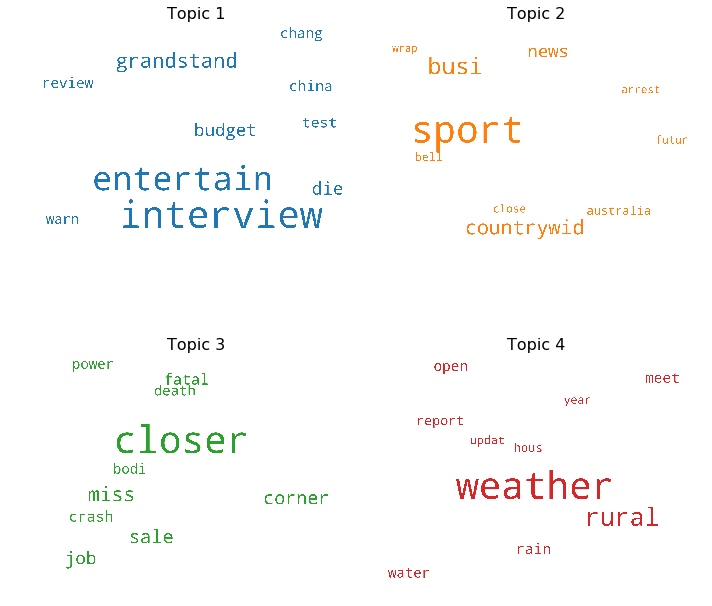

In [39]:
# 1. Wordcloud of Top N words in each topic
cols2 = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud3 = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics2 = lda_model_mallet_4topics.show_topics(formatted=False)

fig2, axes2 = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes2.flatten()):
    fig2.add_subplot(ax)
    topic_words = dict(topics2[i][1])
    cloud3.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud3)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [40]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherencemodel.get_coherence()
        coherence_values.append(coherence_score)
        print("Num Topics = ", num_topics, " has Coherence Value of ", coherence_score)

    return model_list, coherence_values

# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=processed_docs, start=2, limit=20, step=2)

Num Topics =  2  has Coherence Value of  0.609790471889881
Num Topics =  4  has Coherence Value of  0.5071486390468577
Num Topics =  6  has Coherence Value of  0.4800583185055712
Num Topics =  8  has Coherence Value of  0.4725015442584691
Num Topics =  10  has Coherence Value of  0.46992324128298135
Num Topics =  12  has Coherence Value of  0.43937880042165545
Num Topics =  14  has Coherence Value of  0.44909164638296806
Num Topics =  16  has Coherence Value of  0.468885293810879
Num Topics =  18  has Coherence Value of  0.4484850030764603


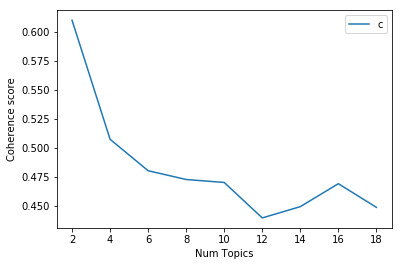

In [41]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [42]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6098
Num Topics = 4  has Coherence Value of 0.5071
Num Topics = 6  has Coherence Value of 0.4801
Num Topics = 8  has Coherence Value of 0.4725
Num Topics = 10  has Coherence Value of 0.4699
Num Topics = 12  has Coherence Value of 0.4394
Num Topics = 14  has Coherence Value of 0.4491
Num Topics = 16  has Coherence Value of 0.4689
Num Topics = 18  has Coherence Value of 0.4485


## Validating our topic models - how well can they classify articles into one of the topics?

### Performance evaluation by classifying sample document using LDA Bag of Words model

In [43]:
processed_docs[3000]

['briton', 'make', 'second', 'row', 'attempt']

In [44]:
for index, score in sorted(lda_model[bow_corpus[3000]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))


Score: 0.300295352935791	 
Topic: 0.035*"australia" + 0.022*"melbourn" + 0.021*"world" + 0.017*"open" + 0.014*"final" + 0.013*"donald" + 0.012*"sydney" + 0.010*"leagu" + 0.010*"take" + 0.010*"road"

Score: 0.21737168729305267	 
Topic: 0.035*"govern" + 0.021*"test" + 0.018*"rural" + 0.014*"break" + 0.012*"school" + 0.012*"news" + 0.011*"busi" + 0.010*"violenc" + 0.010*"say" + 0.009*"worker"

Score: 0.19899491965770721	 
Topic: 0.029*"charg" + 0.027*"court" + 0.021*"murder" + 0.018*"woman" + 0.018*"face" + 0.016*"die" + 0.016*"alleg" + 0.015*"brisban" + 0.015*"live" + 0.015*"jail"

Score: 0.18333320319652557	 
Topic: 0.027*"south" + 0.025*"kill" + 0.015*"island" + 0.013*"fall" + 0.011*"attack" + 0.010*"forc" + 0.009*"shark" + 0.009*"east" + 0.007*"northern" + 0.007*"bring"

Score: 0.01666867546737194	 
Topic: 0.019*"council" + 0.015*"power" + 0.013*"farmer" + 0.011*"industri" + 0.011*"guilti" + 0.011*"christma" + 0.010*"region" + 0.009*"research" + 0.009*"look" + 0.009*"energi"

Score: 

Our test document has the highest probability to be part of the topic on the top.

## Performance evaluation by classifying sample document using LDA TF-IDF model

In [45]:
for index, score in sorted(lda_model_tfidf[bow_corpus[3000]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))


Score: 0.6209820508956909	 
Topic: 0.020*"polic" + 0.019*"charg" + 0.016*"murder" + 0.013*"court" + 0.012*"alleg" + 0.011*"death" + 0.011*"jail" + 0.011*"woman" + 0.010*"arrest" + 0.009*"assault"

Score: 0.24565459787845612	 
Topic: 0.018*"countri" + 0.017*"hour" + 0.010*"interview" + 0.009*"govern" + 0.006*"abbott" + 0.005*"wall" + 0.005*"cut" + 0.005*"asylum" + 0.005*"say" + 0.004*"union"

Score: 0.016671421006321907	 
Topic: 0.008*"final" + 0.007*"leagu" + 0.007*"sport" + 0.006*"peter" + 0.005*"decemb" + 0.005*"open" + 0.005*"rain" + 0.005*"world" + 0.005*"dairi" + 0.005*"murray"

Score: 0.016671055927872658	 
Topic: 0.010*"donald" + 0.009*"australia" + 0.007*"kill" + 0.006*"wednesday" + 0.005*"syria" + 0.005*"islam" + 0.005*"zealand" + 0.005*"australian" + 0.005*"russia" + 0.005*"suicid"

Score: 0.01667081192135811	 
Topic: 0.012*"market" + 0.011*"podcast" + 0.011*"drum" + 0.010*"turnbul" + 0.009*"share" + 0.006*"dollar" + 0.006*"australian" + 0.006*"tuesday" + 0.006*"mother" + 0.

The test document has the highest probability to be part of the topic on the top.

## Performance evaluation by classifying sample document using the 4 topic model trained using Mallet and TF-IDF

In [46]:
# for index, score in sorted(lda_model_mallet_4topics[corpus_tfidf[3000]], key=lambda tup: -1*tup[1]):
#     print("\nScore: {}\t \nTopic: {}".format(score, lda_model_mallet_4topics.print_topic(index, 4)))

## Testing model on unseen document

In [47]:
unseen_document = 'First-time fisherman calls Border Force after becoming stranded in crocodile-infested river'
bow_vector = dictionary.doc2bow(preprocess(unseen_document))

for index, score in sorted(lda_model_tfidf[bow_vector], key=lambda tup: -1*tup[1]):
    print("Score: {}\t Topic: {}".format(score, lda_model.print_topic(index, 5)))

Score: 0.4068733751773834	 Topic: 0.019*"nation" + 0.018*"coast" + 0.016*"help" + 0.016*"countri" + 0.015*"state"
Score: 0.31188517808914185	 Topic: 0.035*"govern" + 0.021*"test" + 0.018*"rural" + 0.014*"break" + 0.012*"school"
Score: 0.21122941374778748	 Topic: 0.037*"trump" + 0.032*"australian" + 0.019*"queensland" + 0.014*"leav" + 0.014*"australia"
Score: 0.01000365149229765	 Topic: 0.027*"south" + 0.025*"kill" + 0.015*"island" + 0.013*"fall" + 0.011*"attack"
Score: 0.010001669637858868	 Topic: 0.019*"canberra" + 0.018*"market" + 0.014*"rise" + 0.014*"west" + 0.014*"australian"
Score: 0.010001661255955696	 Topic: 0.029*"charg" + 0.027*"court" + 0.021*"murder" + 0.018*"woman" + 0.018*"face"
Score: 0.010001637041568756	 Topic: 0.019*"council" + 0.015*"power" + 0.013*"farmer" + 0.011*"industri" + 0.011*"guilti"
Score: 0.010001281276345253	 Topic: 0.063*"polic" + 0.024*"crash" + 0.019*"interview" + 0.019*"miss" + 0.018*"shoot"
Score: 0.010001139715313911	 Topic: 0.035*"australia" + 0.02

## References

?) Vector space model, Wikipedia : https://en.wikipedia.org/wiki/Vector_space_model
?) https://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization
?) Wordnet : https://wordnet.princeton.edu/
?) A Gentle Introduction to the Bag-of-Words Model : https://machinelearningmastery.com/gentle-introduction-bag-words-model/